# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [36]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

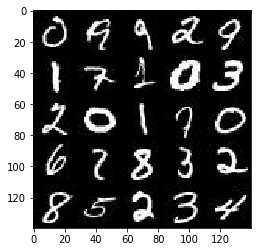

In [37]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

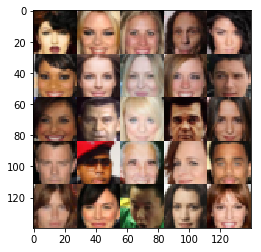

In [38]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [40]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='input_lr')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [41]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
#        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
#        bn3 = tf.layers.batch_normalization(x3, training=True)
#        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [65]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
#    sample_z = np.random.uniform(-1, 1, size=(25, z_dim))

    samples, losses = [], []
    steps = 0
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={lr: learning_rate, input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={lr: learning_rate, input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({lr: learning_rate, input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({lr: learning_rate, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], "RGB")

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7879... Generator Loss: 0.3097
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.7487... Generator Loss: 0.5844
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.7323
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.5628... Generator Loss: 0.3128
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.1665


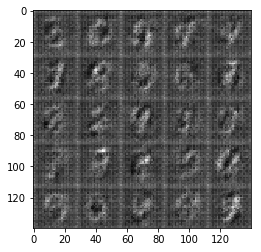

Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 1.6271
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.5090
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.3926
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.4364
Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 1.1426
Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 1.2418
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.3375
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.0605


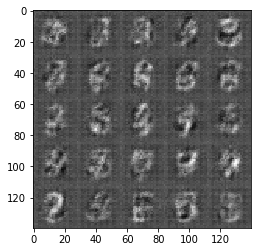

Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 0.5397
Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 1.6953
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 2.2393
Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 1.3676
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 1.5980
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 2.0653
Epoch 1/2... Discriminator Loss: 0.7410... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 1.5617
Epoch 1/2... Discriminator Loss: 0.6791... Generator Loss: 1.6006
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 1.6065


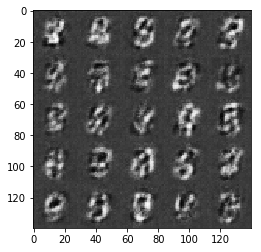

Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 1.4249
Epoch 1/2... Discriminator Loss: 0.5832... Generator Loss: 1.3701
Epoch 1/2... Discriminator Loss: 0.5698... Generator Loss: 1.6244
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 2.1564
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 1.2802
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 1.4629
Epoch 1/2... Discriminator Loss: 0.5198... Generator Loss: 1.8488
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 0.5199... Generator Loss: 2.0334


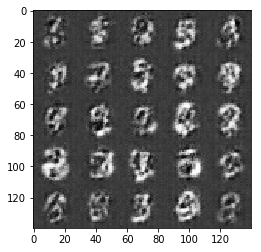

Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.1060
Epoch 1/2... Discriminator Loss: 0.5122... Generator Loss: 2.0290
Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 1.8686
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 2.1073
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 1.8317
Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 1.5507
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 1.6987
Epoch 2/2... Discriminator Loss: 0.3794... Generator Loss: 2.1441
Epoch 2/2... Discriminator Loss: 0.4116... Generator Loss: 2.3039
Epoch 2/2... Discriminator Loss: 0.3939... Generator Loss: 1.9137


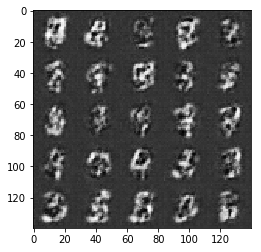

Epoch 2/2... Discriminator Loss: 0.3434... Generator Loss: 2.2423
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 2.4537
Epoch 2/2... Discriminator Loss: 0.3409... Generator Loss: 2.4995
Epoch 2/2... Discriminator Loss: 0.3401... Generator Loss: 2.0249
Epoch 2/2... Discriminator Loss: 0.4102... Generator Loss: 1.4076
Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 1.5668
Epoch 2/2... Discriminator Loss: 0.2892... Generator Loss: 1.8835
Epoch 2/2... Discriminator Loss: 0.3642... Generator Loss: 1.5857
Epoch 2/2... Discriminator Loss: 0.2999... Generator Loss: 2.0250


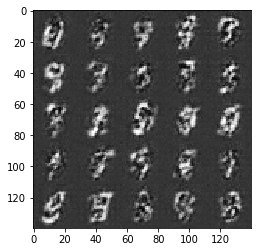

Epoch 2/2... Discriminator Loss: 0.2968... Generator Loss: 1.9564
Epoch 2/2... Discriminator Loss: 0.2756... Generator Loss: 1.9976
Epoch 2/2... Discriminator Loss: 0.3135... Generator Loss: 1.7517
Epoch 2/2... Discriminator Loss: 0.3393... Generator Loss: 1.5928
Epoch 2/2... Discriminator Loss: 0.2565... Generator Loss: 2.2698
Epoch 2/2... Discriminator Loss: 0.2944... Generator Loss: 2.5886
Epoch 2/2... Discriminator Loss: 0.3755... Generator Loss: 2.9247
Epoch 2/2... Discriminator Loss: 0.2638... Generator Loss: 2.7490
Epoch 2/2... Discriminator Loss: 0.2086... Generator Loss: 2.5062
Epoch 2/2... Discriminator Loss: 0.2088... Generator Loss: 2.3298


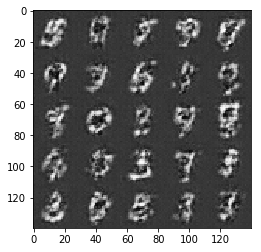

Epoch 2/2... Discriminator Loss: 0.2369... Generator Loss: 2.1688
Epoch 2/2... Discriminator Loss: 0.2297... Generator Loss: 2.1741
Epoch 2/2... Discriminator Loss: 0.2463... Generator Loss: 2.1878
Epoch 2/2... Discriminator Loss: 0.3424... Generator Loss: 3.5157
Epoch 2/2... Discriminator Loss: 0.2329... Generator Loss: 2.6261
Epoch 2/2... Discriminator Loss: 0.2642... Generator Loss: 2.0023
Epoch 2/2... Discriminator Loss: 0.3524... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 0.2743... Generator Loss: 2.1009
Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 2.5138
Epoch 2/2... Discriminator Loss: 0.2231... Generator Loss: 2.6269


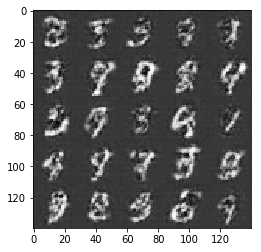

Epoch 2/2... Discriminator Loss: 0.2604... Generator Loss: 2.2683
Epoch 2/2... Discriminator Loss: 0.2842... Generator Loss: 1.8426
Epoch 2/2... Discriminator Loss: 0.2180... Generator Loss: 2.2231
Epoch 2/2... Discriminator Loss: 0.2364... Generator Loss: 2.1282
Epoch 2/2... Discriminator Loss: 0.2092... Generator Loss: 2.4275
Epoch 2/2... Discriminator Loss: 0.1916... Generator Loss: 2.5093
Epoch 2/2... Discriminator Loss: 0.2283... Generator Loss: 2.1656
Epoch 2/2... Discriminator Loss: 0.2144... Generator Loss: 2.3869
Epoch 2/2... Discriminator Loss: 0.2044... Generator Loss: 2.4430
Epoch 2/2... Discriminator Loss: 0.3995... Generator Loss: 4.0190


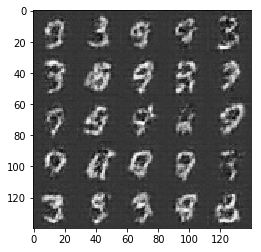

Epoch 2/2... Discriminator Loss: 0.2402... Generator Loss: 2.5377
Epoch 2/2... Discriminator Loss: 0.2399... Generator Loss: 2.5162
Epoch 2/2... Discriminator Loss: 0.2089... Generator Loss: 2.4585


In [64]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.9169... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.3245
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.3996


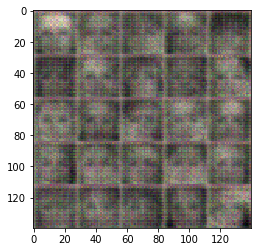

Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.7048
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 1.6783
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 1.5110
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 2.4007
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 1.6331
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 4.9316
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 4.9912


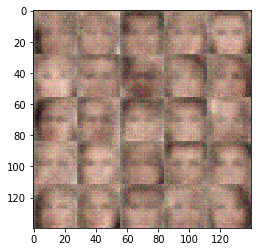

Epoch 1/1... Discriminator Loss: 1.9092... Generator Loss: 0.1990
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 4.5799
Epoch 1/1... Discriminator Loss: 0.2895... Generator Loss: 5.5945
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 1.8802
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.3600
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.2771
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.6023


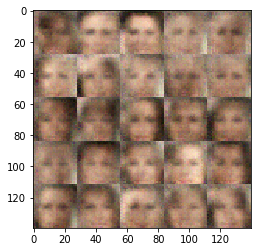

Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 5.6310
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 2.4387
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 5.2159
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.0917
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 2.0587
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 2.8009
Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.9649
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 4.2865


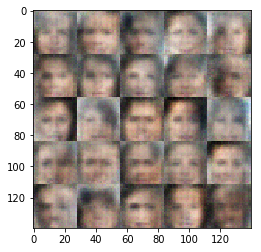

Epoch 1/1... Discriminator Loss: 0.2727... Generator Loss: 2.9518
Epoch 1/1... Discriminator Loss: 0.0905... Generator Loss: 4.8932
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 1.9081
Epoch 1/1... Discriminator Loss: 0.4790... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 5.9519
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 2.2834
Epoch 1/1... Discriminator Loss: 0.1694... Generator Loss: 3.7033
Epoch 1/1... Discriminator Loss: 0.2000... Generator Loss: 5.9465
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.1169


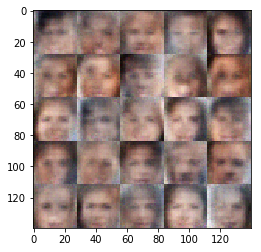

Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 6.8492
Epoch 1/1... Discriminator Loss: 0.1920... Generator Loss: 2.2910
Epoch 1/1... Discriminator Loss: 0.2535... Generator Loss: 2.7373
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 1.5406
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 1.8235... Generator Loss: 0.2138


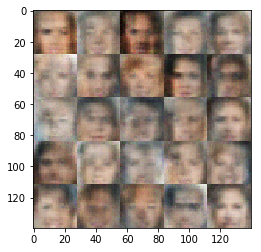

Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 0.1763... Generator Loss: 4.6728
Epoch 1/1... Discriminator Loss: 0.2912... Generator Loss: 6.1052
Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 4.3742
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 0.2914... Generator Loss: 2.7671
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 7.5535
Epoch 1/1... Discriminator Loss: 0.3143... Generator Loss: 5.7362
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.2798


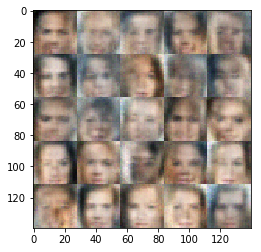

Epoch 1/1... Discriminator Loss: 0.2210... Generator Loss: 2.8343
Epoch 1/1... Discriminator Loss: 2.5213... Generator Loss: 0.1018
Epoch 1/1... Discriminator Loss: 0.2339... Generator Loss: 7.9120
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 0.6503... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.2198... Generator Loss: 5.3397
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 0.2004... Generator Loss: 7.2960


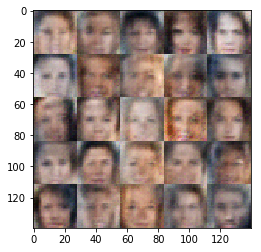

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.3661
Epoch 1/1... Discriminator Loss: 0.4556... Generator Loss: 5.2049
Epoch 1/1... Discriminator Loss: 0.2480... Generator Loss: 7.4848
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 4.4654
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 4.0715
Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 2.8238


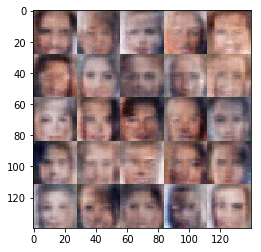

Epoch 1/1... Discriminator Loss: 0.2482... Generator Loss: 5.5449
Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 2.7475
Epoch 1/1... Discriminator Loss: 0.0786... Generator Loss: 6.1790
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.2835
Epoch 1/1... Discriminator Loss: 0.2144... Generator Loss: 2.9556
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 1.0819


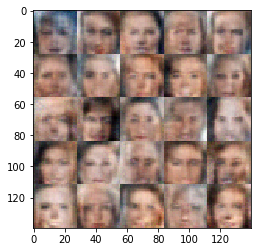

Epoch 1/1... Discriminator Loss: 0.3028... Generator Loss: 4.4869
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 10.4015
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 7.1972
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 0.2505... Generator Loss: 4.8850
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 3.0054
Epoch 1/1... Discriminator Loss: 0.1252... Generator Loss: 4.8770
Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 7.4022
Epoch 1/1... Discriminator Loss: 0.2027... Generator Loss: 5.5120


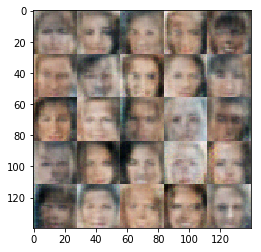

Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 5.8583
Epoch 1/1... Discriminator Loss: 0.1678... Generator Loss: 6.5268
Epoch 1/1... Discriminator Loss: 0.3334... Generator Loss: 3.0856
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 0.2919... Generator Loss: 3.2242
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 0.1339... Generator Loss: 5.5410
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 0.1389... Generator Loss: 6.5580


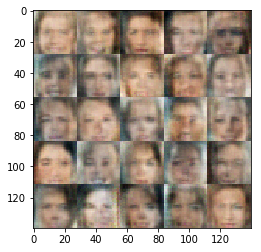

Epoch 1/1... Discriminator Loss: 0.1271... Generator Loss: 6.9691
Epoch 1/1... Discriminator Loss: 0.2077... Generator Loss: 5.4350
Epoch 1/1... Discriminator Loss: 0.2037... Generator Loss: 3.6575
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 1.8356
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 3.3291
Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 0.0512... Generator Loss: 8.8306
Epoch 1/1... Discriminator Loss: 0.3085... Generator Loss: 6.3448
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 4.9146
Epoch 1/1... Discriminator Loss: 0.2947... Generator Loss: 3.2704


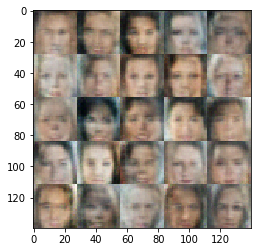

Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 6.6169
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 5.8256
Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 4.1953
Epoch 1/1... Discriminator Loss: 0.2039... Generator Loss: 6.6582
Epoch 1/1... Discriminator Loss: 0.0845... Generator Loss: 12.7716
Epoch 1/1... Discriminator Loss: 0.2011... Generator Loss: 3.4165
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 5.7874
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.0938... Generator Loss: 11.1741
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 4.6264


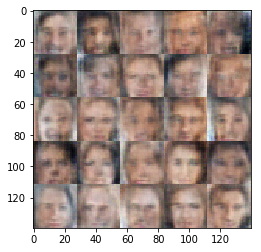

Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 1.9199
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 0.2566... Generator Loss: 13.0813
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 4.3926
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 11.9342
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 6.6867
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 7.5839
Epoch 1/1... Discriminator Loss: 0.1370... Generator Loss: 5.0783
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.7710


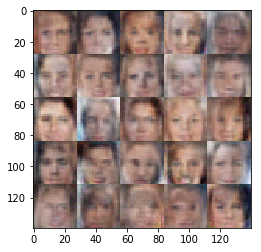

Epoch 1/1... Discriminator Loss: 0.0900... Generator Loss: 8.4243
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 5.1566
Epoch 1/1... Discriminator Loss: 0.1429... Generator Loss: 3.5532
Epoch 1/1... Discriminator Loss: 0.2401... Generator Loss: 2.9824
Epoch 1/1... Discriminator Loss: 0.1222... Generator Loss: 9.8369
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 12.5485
Epoch 1/1... Discriminator Loss: 0.0984... Generator Loss: 7.8420
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 6.6029


In [66]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)